### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Functions

In [2]:
"""
It returns a dataframe with the closing price of the asset 'name' for the input start and end dates
"""
def ReaData(name, St_Date, En_Date):
    data = pd.DataFrame()
    data[name] = wb.DataReader(name, data_source='yahoo', start=St_Date, end=En_Date)['Adj Close']
    return data

In [3]:
"""
Input: a dictionary with dataseries as values.
The function will merge all the series in one dateframe for all the indexes found in all series.
If a series does not have a value for an index, Nan value will be used.
Then, all the rows that have Nan values, will be dropped.
"""
def CreatePort(dct):
    df_list = ([v for k,v in dct.items()])
    portfolio = pd.concat(df_list, axis=1, sort=True)
    portfolio.dropna(inplace=True)
    return portfolio

In [4]:
"""
Monte Carlo simulation for Geometric Brownian Motion.
Inputs: mean, std, initial value, time (in years), steps, and number of interations
Output: projections
"""
def MonteCarlo(mu, sigma, s0, T, steps, iterations):
    delta_t= T/steps
    proj=[] # `proj`: last price value of each iteration
    plt.figure(figsize=(12,6))
    for _ in range(iterations):
        price_path = [s0]  # `price path`: price values for an interation
        st = s0
        for i in range(int(steps)):
            st = st*np.exp((mu-0.5*sigma**2)*delta_t + sigma*np.sqrt(delta_t)*np.random.normal(0, 1))
            price_path.append(st)
        proj.append(st)
        plt.plot(price_path)
    plt.ylabel('stock price',fontsize=15)
    plt.xlabel('steps',fontsize=15)
    plt.show()
    return proj

=====================================================================================================

### Time Series Data Extraction
- risk factors: US market stocks of top 5 companies according to Fortune 500
- Walmart, Exxon, Apple, Berkshire Hathaway, Amazon
- frequency of observations: daily
- date range: 10y
- source: yahoo reader

In [5]:
# stock market acronyms
stock = ['WMT', 'XOM', 'AAPL', 'BRK-A', 'AMZN']

St_Date = "2009-05-01" # starting date of data
En_Date = "2019-04-30" # end date of data


# Getting the closing prices for the 'stock' defined
# Dimensions and dates are printed for validation
data_dct = {}
for key in stock:
    data_dct[key] = ReaData(key, St_Date, En_Date)
    print(key)
    print(' size :  ',data_dct[key].shape)
    print(' from:',data_dct[key].index[0].strftime("%d/%m/%Y"),' to: ', data_dct[key].index[-1].strftime("%d/%m/%Y"))

WMT
 size :   (2516, 1)
 from: 01/05/2009  to:  30/04/2019
XOM
 size :   (2516, 1)
 from: 01/05/2009  to:  30/04/2019
AAPL
 size :   (2516, 1)
 from: 01/05/2009  to:  30/04/2019
BRK-A
 size :   (2516, 1)
 from: 01/05/2009  to:  30/04/2019
AMZN
 size :   (2516, 1)
 from: 01/05/2009  to:  30/04/2019


In [6]:
# All data are combined into 1 dataframe, to create portfolio
portfolio = CreatePort(data_dct)

=====================================================================================================

### Covariance Matrix Calculation

- #### Assuming geometric brownian dynamics, we are interested in the differences of log(Price)

In [7]:
"""
1. Transform  prices into their log form
2. Get difference between consecutive values
3. Drop first row since it's NaN
"""
portfolio_logDiff = (np.log(portfolio)).diff()[1:]

In [8]:
""" Covariance matrix for equally weighted averages """
cov_mat = np.cov(portfolio_logDiff.transpose(), aweights=None)

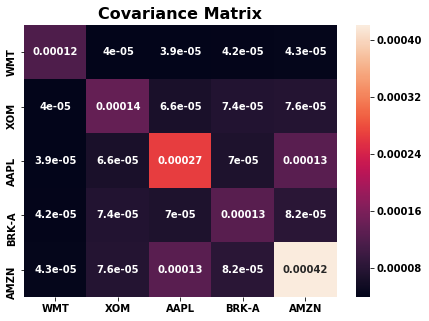

In [9]:
# Plot covariance matrix
plt.figure(figsize=(7,5))
plt.title('Covariance Matrix', size=16)
sns.heatmap(cov_mat, xticklabels=stock, yticklabels=stock, annot=True)
plt.show()

- #### The diagonal of the matrix above represents the variance of each asset, based on historical data of 10 years. The rest of the values are the covariance between 2 assets
- #### High covariance in the portfolio indicates high risk
- #### Assets of low covariance indicate better diversification
- #### For example, AMZN and AAPL show significant volatility, possibly due to the fact that both are tech companies. On the other hand, the covariance of AAPL and WMT is low
- #### The extent to which returns move together can be better depicted in the correlation matrix, as shown below

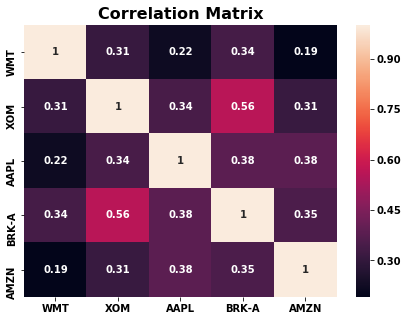

In [10]:
""" Calculation of correlation matrix """
if (np.all(np.linalg.eigvals(cov_mat) > 0)):
    correlation = portfolio_logDiff.corr()
    plt.figure(figsize=(7,5))
    plt.title('Correlation Matrix', size=16)
    sns.heatmap(correlation, xticklabels=stock, yticklabels=stock, annot=True)
    plt.show()

- #### The correlation coefficient of two assets increases, as their returns tend to move together
- #### max(correlation coefficient) == 1

=====================================================================================================

### Monte Carlo Scenarios Generation

In [11]:
"""
Based on the 10y historical data, the returns and the volatility of each stock are annualised
"""
annual_return = (portfolio.iloc[-1,:]/portfolio.iloc[0,:])**(365.0/len(portfolio)) - 1

# 'pct_chng_day' is the day-to-day change in percentage. It is daily returns
pct_chng_day = (portfolio.pct_change())[1:] # we drop the first row since it's Nan
annual_vol   = pct_chng_day.std()*np.sqrt(252)
# sigma_annualised = sigma_daily * square root of 252.
# 252 assumed the trading days per year

- #### The next figure shows the variations of the daily percentage change (daily returns) of the stocks' prices under test. As depicted below they follow a normal distribution with mean value about zero.

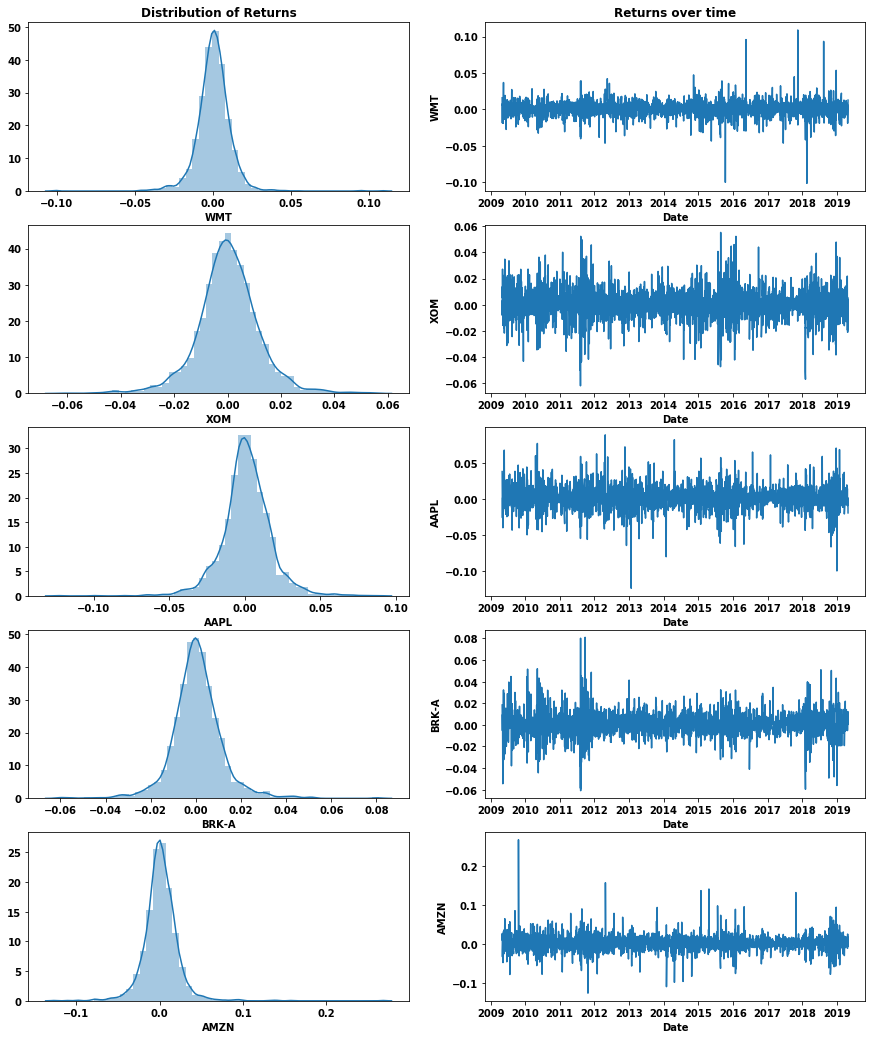

In [12]:
plt.figure(figsize=(15,18))
c=0
for i in range(0,9,2):
    plt.subplot(5,2,i+1)
    if i==0:
        plt.title('Distribution of Returns')
    sns.distplot(pct_chng_day[stock[c]])
    plt.subplot(5,2,i+2)
    if i==0:
        plt.title('Returns over time')
    sns.lineplot(portfolio.index[1:],pct_chng_day[stock[c]])
    c+=1

In [13]:
""" Parameters for Monte Carlo Simulatios """
T          = 1     # prediction time (in years)
steps      = 500   # steps for time 'T'
iterations = 5000  # number of repetitions

WMT


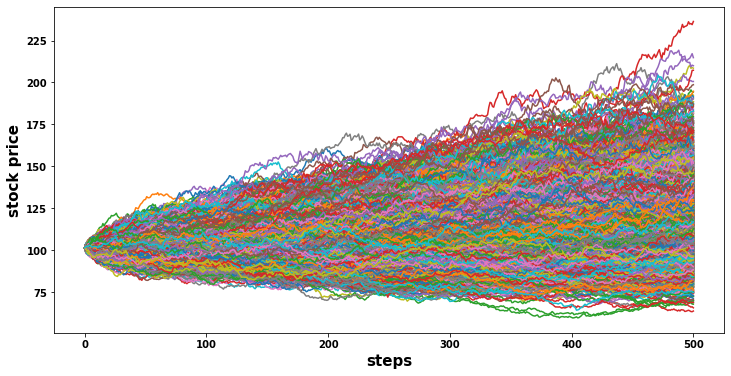

XOM


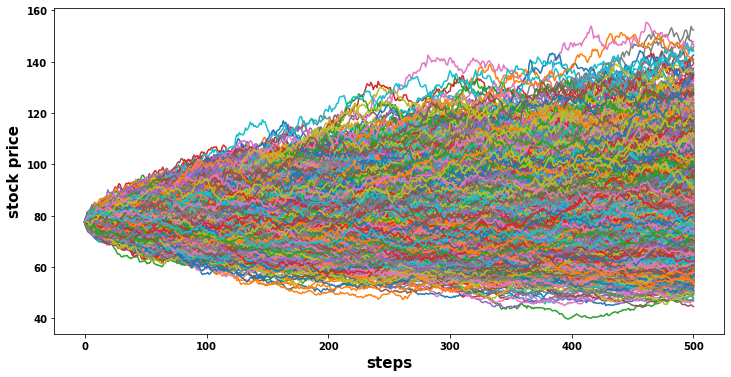

AAPL


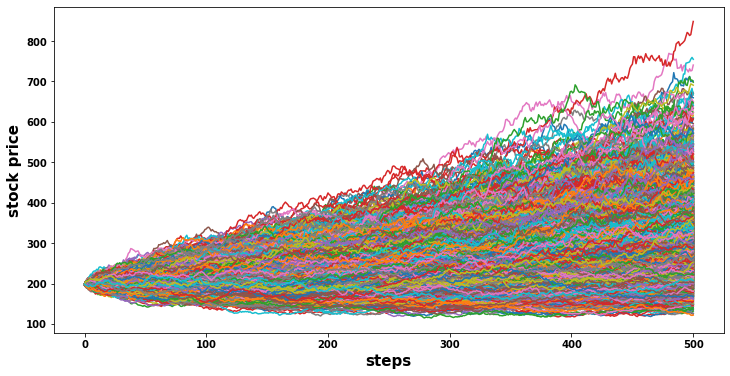

BRK-A


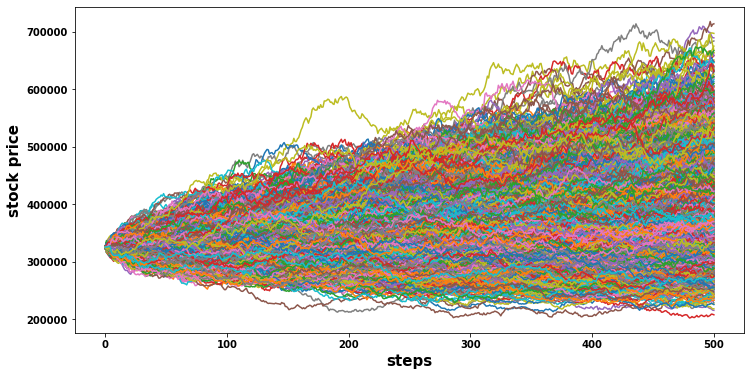

AMZN


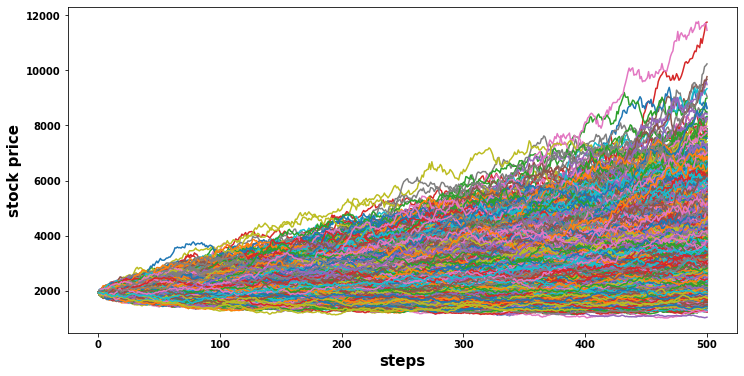

In [14]:
""" Run Simulations """
proj = {}
for i,key in enumerate(stock):
    print(key)
    proj[key] = MonteCarlo(annual_return[i],annual_vol[i],portfolio.iloc[-1,i],T,steps,iterations)

In [15]:
projs = pd.DataFrame.from_dict(proj)

- #### As shown in the figure below, it is the `log(Price)` that is normally distributed
- #### The following histograms are the 1Y projections

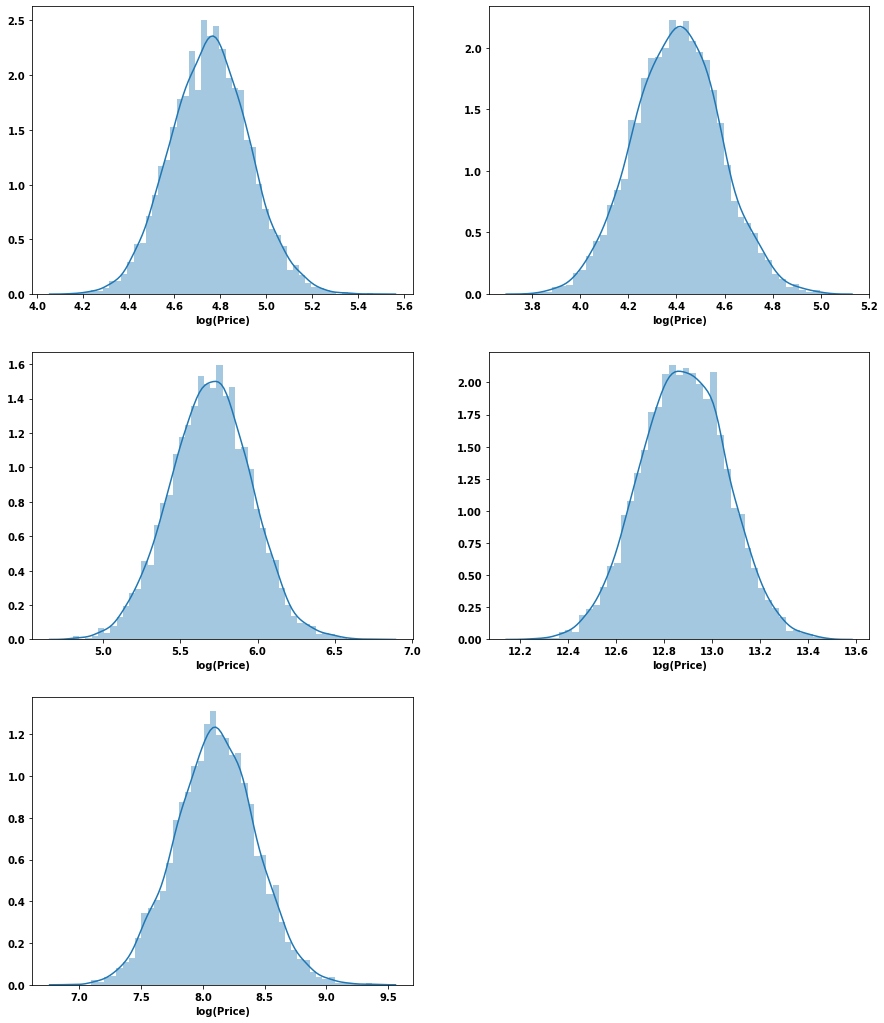

In [16]:
plt.figure(figsize=(15,18))
for i,key in enumerate(stock):
    plt.subplot(3,2,i+1)
    sns.distplot(np.log(projs.iloc[:,i]),axlabel='log(Price)', label=key)
plt.show()

In [17]:
"""
The `projected Price Averages` on 1Y horizon, including the +/-1 standard deviation ranges, are shown
"""
mu_log    = np.mean(np.log(projs))
sigma_log = np.std(np.log(projs))
limit_u   = np.exp(mu_log + sigma_log)
limit_l   = np.exp(mu_log - sigma_log)

print('mean-std < mean < mean+std')
print(' ')
for i,key in enumerate(stock):
    print(key)
    print("{0:.2f}".format(limit_l[i]),' < ', 
          "{0:.2f}".format(np.exp(mu_log[i])),' < ',
          "{0:.2f}".format(limit_u[i]))

mean-std < mean < mean+std
 
WMT
97.99  <  116.24  <  137.90
XOM
68.19  <  81.67  <  97.82
AAPL
228.72  <  297.21  <  386.21
BRK-A
327371.26  <  391714.91  <  468705.08
AMZN
2376.38  <  3295.75  <  4570.79


In [18]:
"""
Calculating the `Expected Returns` in the 1Y horizon
"""
s0 = portfolio.iloc[-1,:] # Initial Price
sL = np.exp(mu_log)       # Expected Average in 1Y

(sL/s0)-1 # Returns = (End_Price/Init_Price)**(1/Len_Years) - 1

WMT      0.147034
XOM      0.054354
AAPL     0.496930
BRK-A    0.204980
AMZN     0.710725
dtype: float64